In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [ ]:
# 1) Load + Data Understanding

RANDOM_STATE = 42
url = ""
df = pd.read_csv(url)

print("=== Business Objective ===")
print(
    "Tujuan: Memprediksi 'Sleep Disorder' (None/Insomnia/Sleep Apnea) berdasarkan "
    "data gaya hidup dan kesehatan (aktivitas, stress, kualitas tidur, tekanan darah, dll) "
    "supaya bisa bantu identifikasi risiko gangguan tidur lebih cepat.\n"
)

print("=== Basic Info ===")
print("Shape:", df.shape)
print("\nKolom:", list(df.columns))

print("\n=== Data Types ===")
print(df.dtypes)

print("\n=== Missing Values (raw) ===")
print(df.isna().sum())

print("\n=== Sample Rows ===")
print(df.head(5))

# data description
col_desc = {
    "Person ID": "ID unik tiap orang",
    "Gender": "Jenis kelamin (Male/Female)",
    "Age": "Umur (tahun)",
    "Occupation": "Pekerjaan",
    "Sleep Duration": "Durasi tidur (jam)",
    "Quality of Sleep": "Kualitas tidur (skala angka)",
    "Physical Activity Level": "Level aktivitas fisik (skala angka)",
    "Stress Level": "Level stres (skala angka)",
    "BMI Category": "Kategori BMI (Normal/Overweight/Obese)",
    "Blood Pressure": "Tekanan darah format 'sistolik/diastolik'",
    "Heart Rate": "Detak jantung",
    "Daily Steps": "Langkah harian",
    "Sleep Disorder": "Target label (None/Insomnia/Sleep Apnea)"
}
print("\n=== Data Description ===")
for k, v in col_desc.items():
    print(f"- {k}: {v}")

=== Business Objective ===
Tujuan: Memprediksi 'Sleep Disorder' (None/Insomnia/Sleep Apnea) berdasarkan data gaya hidup dan kesehatan (aktivitas, stress, kualitas tidur, tekanan darah, dll) supaya bisa bantu identifikasi risiko gangguan tidur lebih cepat.

=== Basic Info ===
Shape: (374, 13)

Kolom: ['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder']

=== Data Types ===
Person ID                    int64
Gender                      object
Age                          int64
Occupation                  object
Sleep Duration             float64
Quality of Sleep             int64
Physical Activity Level      int64
Stress Level                 int64
BMI Category                object
Blood Pressure              object
Heart Rate                   int64
Daily Steps                  int64
Sleep Disorder              object
dtype: object

==

In [4]:
# 2) Data Preparation (cleaning)

df_clean = df.copy()

# 2.1 handle missing target
df_clean["Sleep Disorder"] = df_clean["Sleep Disorder"].fillna("None")

# 2.2 rapihin kategori BMI 
df_clean["BMI Category"] = df_clean["BMI Category"].replace({"Normal Weight": "Normal"})

# 2.3 feature engineering awal: pecah Blood Pressure jadi 2 kolom angka
# format contoh: "126/83"
bp_split = df_clean["Blood Pressure"].astype(str).str.split("/", expand=True)
df_clean["BP_Systolic"] = pd.to_numeric(bp_split[0], errors="coerce")
df_clean["BP_Diastolic"] = pd.to_numeric(bp_split[1], errors="coerce")

# drop yang stringnya
df_clean = df_clean.drop(columns=["Blood Pressure"])

# 2.4 cek duplikasi
dup_count = df_clean.duplicated().sum()
print("\nDuplicated rows:", dup_count)

# 2.5 cek missing setelah cleaning + BP parse
print("\n=== Missing Values (after prep) ===")
print(df_clean.isna().sum())

# 2.6 outlier handling simple (winsorize ringan) buat kolom numerik

num_cols_all = df_clean.select_dtypes(include=[np.number]).columns.tolist()
num_cols_all = [c for c in num_cols_all if c != "Person ID"]  # ID ga usah
for c in num_cols_all:
    lo = df_clean[c].quantile(0.01)
    hi = df_clean[c].quantile(0.99)
    df_clean[c] = df_clean[c].clip(lo, hi)

print("\n=== Numeric Summary (after outlier clip) ===")
print(df_clean[num_cols_all].describe().T)


Duplicated rows: 0

=== Missing Values (after prep) ===
Person ID                  0
Gender                     0
Age                        0
Occupation                 0
Sleep Duration             0
Quality of Sleep           0
Physical Activity Level    0
Stress Level               0
BMI Category               0
Heart Rate                 0
Daily Steps                0
Sleep Disorder             0
BP_Systolic                0
BP_Diastolic               0
dtype: int64

=== Numeric Summary (after outlier clip) ===
                         count         mean          std     min      25%  \
Age                      374.0    42.187166     8.668593    28.0    35.25   
Sleep Duration           374.0     7.132620     0.794792     5.9     6.40   
Quality of Sleep         374.0     7.312834     1.196956     4.0     6.00   
Physical Activity Level  374.0    59.171123    20.830804    30.0    45.00   
Stress Level             374.0     5.385027     1.774526     3.0     4.00   
Heart Rate      


=== Target Distribution ===
Sleep Disorder
None           219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64


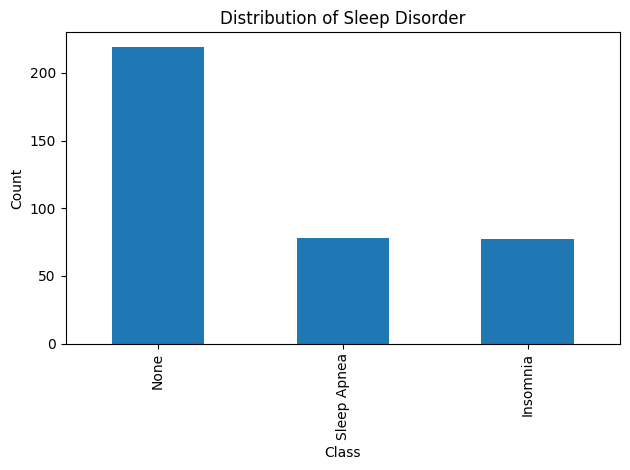

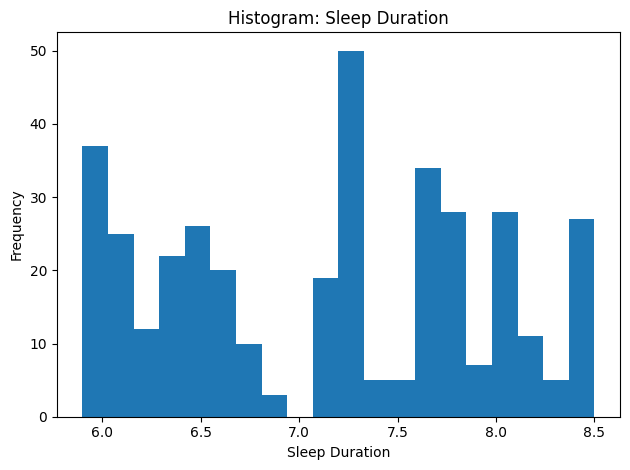

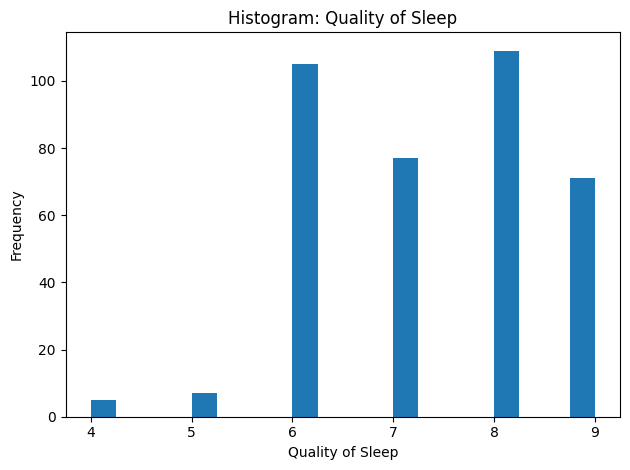

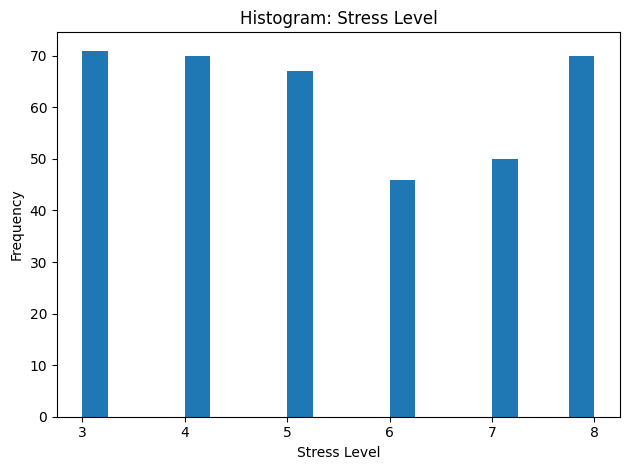

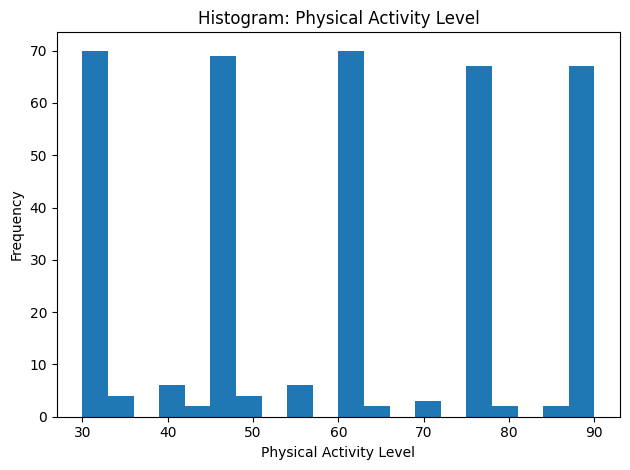

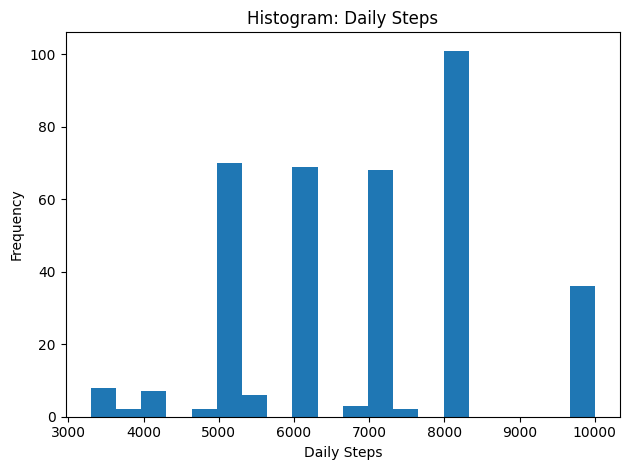

In [5]:
# 3) EDA + Visualization

print("\n=== Target Distribution ===")
print(df_clean["Sleep Disorder"].value_counts())

plt.figure()
df_clean["Sleep Disorder"].value_counts().plot(kind="bar")
plt.title("Distribution of Sleep Disorder")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# histogram beberapa variabel penting
for col in ["Sleep Duration", "Quality of Sleep", "Stress Level", "Physical Activity Level", "Daily Steps"]:
    plt.figure()
    plt.hist(df_clean[col], bins=20)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


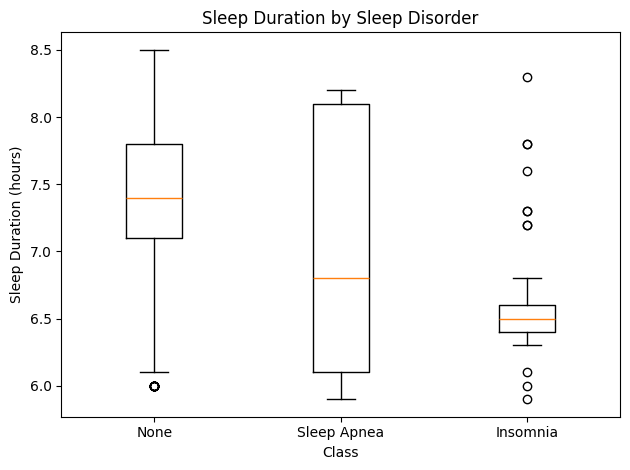

In [6]:
# boxplot sleep duration by class (simple)
plt.figure()
classes = df_clean["Sleep Disorder"].unique()
data_box = [df_clean.loc[df_clean["Sleep Disorder"] == k, "Sleep Duration"].values for k in classes]
plt.boxplot(data_box, labels=classes)
plt.title("Sleep Duration by Sleep Disorder")
plt.xlabel("Class")
plt.ylabel("Sleep Duration (hours)")
plt.tight_layout()
plt.show()

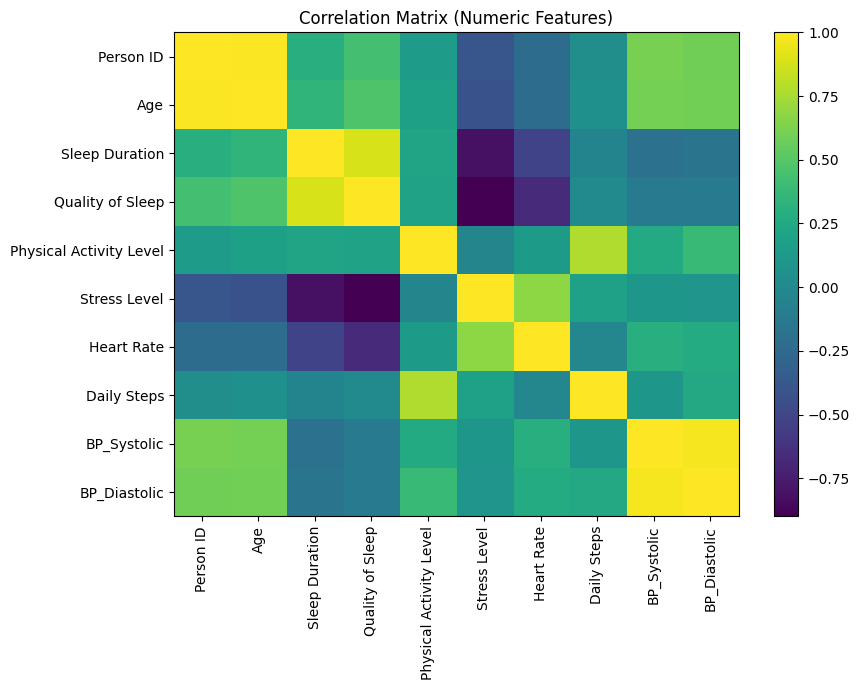

In [7]:
# correlation heatmap (manual pakai imshow biar ga ribet)
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
corr = df_clean[numeric_cols].corr()

plt.figure(figsize=(9, 7))
plt.imshow(corr.values, aspect="auto")
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Correlation Matrix (Numeric Features)")
plt.tight_layout()
plt.show()

In [8]:
# 4) Feature Engineering

df_clean["Activity_Bin"] = pd.cut(
    df_clean["Physical Activity Level"],
    bins=[-np.inf, 35, 55, np.inf],
    labels=["Low", "Medium", "High"]
)

df_clean["Steps_Bin"] = pd.cut(
    df_clean["Daily Steps"],
    bins=[-np.inf, 5000, 9000, np.inf],
    labels=["LowSteps", "MidSteps", "HighSteps"]
)

print("\nActivity_Bin counts:\n", df_clean["Activity_Bin"].value_counts(dropna=False))
print("\nSteps_Bin counts:\n", df_clean["Steps_Bin"].value_counts(dropna=False))


Activity_Bin counts:
 Activity_Bin
High      213
Medium     87
Low        74
Name: count, dtype: int64

Steps_Bin counts:
 Steps_Bin
MidSteps     251
LowSteps      87
HighSteps     36
Name: count, dtype: int64


In [9]:
# 5) Modeling - Classification

target = "Sleep Disorder"

# buang ID karena cuma identifier, bukan fitur
X = df_clean.drop(columns=[target, "Person ID"])
y = df_clean[target]

# split train/test stratified biar kelasnya seimbang
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# pisah kolom numeric vs categorical
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("\nNumeric features:", numeric_features)
print("Categorical features:", categorical_features)

# preprocessing:
# - numeric: median imputer + standard scaler
# - cat: most_frequent + onehot
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ],
    remainder="drop"
)

# baseline models (biar memenuhi "compare > 1 model configuration")
models = {
    "LogReg": LogisticRegression(max_iter=500, multi_class="auto"),
    "RF_Base": RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE,
        class_weight="balanced"
    ),
    "GB": GradientBoostingClassifier(random_state=RANDOM_STATE)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("\n=== Cross-Validation (Train set) ===")
cv_results = []
for name, clf in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("model", clf)])
    scores = cross_validate(
        pipe,
        X_train, y_train,
        cv=cv,
        scoring=["accuracy", "f1_macro"],
        n_jobs=-1
    )
    row = {
        "model": name,
        "acc_mean": scores["test_accuracy"].mean(),
        "acc_std": scores["test_accuracy"].std(),
        "f1_macro_mean": scores["test_f1_macro"].mean(),
        "f1_macro_std": scores["test_f1_macro"].std()
    }
    cv_results.append(row)

cv_df = pd.DataFrame(cv_results).sort_values(by="f1_macro_mean", ascending=False)
print(cv_df.to_string(index=False))


Numeric features: ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps', 'BP_Systolic', 'BP_Diastolic']
Categorical features: ['Gender', 'Occupation', 'BMI Category', 'Activity_Bin', 'Steps_Bin']

=== Cross-Validation (Train set) ===
  model  acc_mean  acc_std  f1_macro_mean  f1_macro_std
 LogReg  0.889492 0.023512       0.863144      0.028344
     GB  0.879605 0.026629       0.851312      0.039875
RF_Base  0.852881 0.038440       0.827123      0.042491


In [10]:
# 6) Hyperparameter Tuning (GridSearchCV) - RF

rf_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced"))
])

param_grid = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [None, 6, 10, 14],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

grid = GridSearchCV(
    rf_pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=0
)

grid.fit(X_train, y_train)

print("\n=== Best RF Params (GridSearch) ===")
print(grid.best_params_)
print("Best CV f1_macro:", grid.best_score_)


=== Best RF Params (GridSearch) ===
{'model__max_depth': 6, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best CV f1_macro: 0.8606261129041288



=== Test Metrics ===
Accuracy: 0.96

Classification Report:
              precision    recall  f1-score   support

    Insomnia     0.9286    0.8667    0.8966        15
        None     1.0000    1.0000    1.0000        44
 Sleep Apnea     0.8824    0.9375    0.9091        16

    accuracy                         0.9600        75
   macro avg     0.9370    0.9347    0.9352        75
weighted avg     0.9606    0.9600    0.9599        75



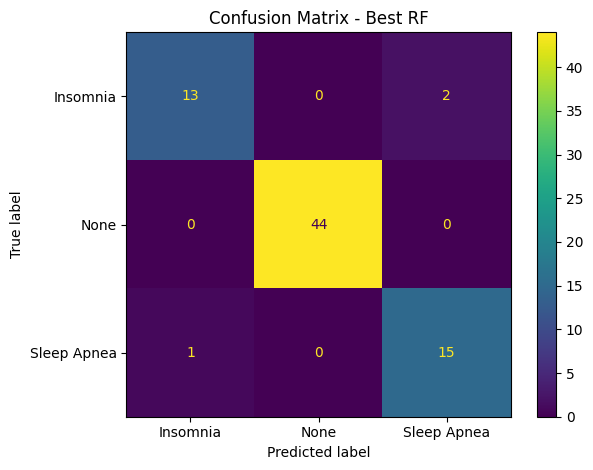

In [11]:
# 7) Final Evaluation on Test Set

best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("\n=== Test Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
plt.title("Confusion Matrix - Best RF")
plt.tight_layout()
plt.show()


=== Top 15 Important Features (RF) ===
                feature  importance
            BP_Systolic    0.132462
           BP_Diastolic    0.121128
    BMI Category_Normal    0.101667
       Occupation_Nurse    0.100290
BMI Category_Overweight    0.070936
         Sleep Duration    0.066630
Physical Activity Level    0.057807
    Activity_Bin_Medium    0.057024
            Daily Steps    0.055810
                    Age    0.054314
             Heart Rate    0.028547
       Quality of Sleep    0.026977
      Activity_Bin_High    0.026344
           Stress Level    0.012727
     Steps_Bin_MidSteps    0.010636


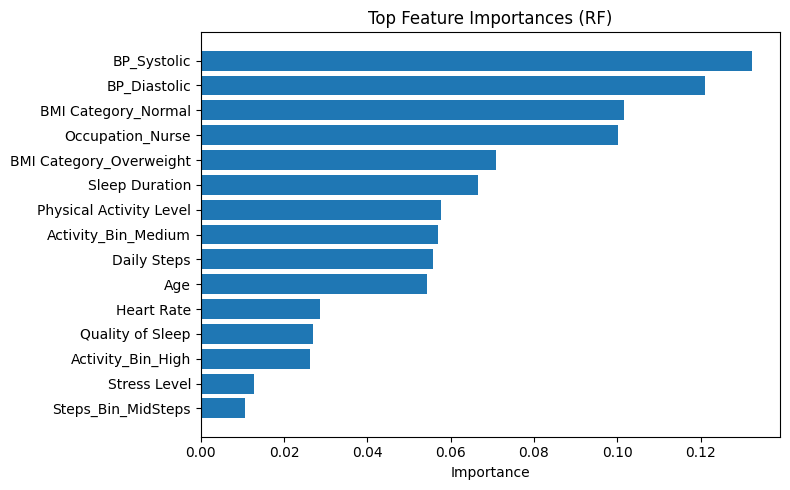

In [12]:
# 8) Interpretation (Feature Importance)

# ambil feature names setelah onehot
prep_fitted = best_model.named_steps["prep"]
ohe = prep_fitted.named_transformers_["cat"].named_steps["onehot"]

cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_features, cat_feature_names])

rf = best_model.named_steps["model"]
importances = rf.feature_importances_

imp_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\n=== Top 15 Important Features (RF) ===")
print(imp_df.head(15).to_string(index=False))

plt.figure(figsize=(8, 5))
top_k = 15
plt.barh(imp_df.head(top_k)["feature"][::-1], imp_df.head(top_k)["importance"][::-1])
plt.title("Top Feature Importances (RF)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [14]:
# 9) Conclusion 

conclusion = """
=========================
CONCLUSION
=========================

1) Hasil Perbandingan Model (Stratified 5-Fold CV - Train Set)
- Logistic Regression  : F1-macro mean ≈ 0.863 | Accuracy mean ≈ 0.889
- Gradient Boosting    : F1-macro mean ≈ 0.851
- Random Forest (base) : F1-macro mean ≈ 0.827

Catatan:
- Logistic Regression paling stabil pada evaluasi cross-validation.
- Random Forest baseline paling rendah, namun tetap dilanjutkan tuning karena bisa memberi interpretasi feature importance.

2) Hasil Tuning Random Forest (GridSearchCV)
Best Parameters:
- max_depth         = 6
- n_estimators      = 200
- min_samples_split = 2
- min_samples_leaf  = 1

Best CV F1-macro ≈ 0.861

3) Evaluasi Model Final pada Test Set
- Accuracy           = 0.96
- Macro-average F1   ≈ 0.935
- Weighted-average F1≈ 0.960

Ringkasan per kelas:
- None        : precision/recall/F1 = 1.00 (model sangat konsisten)
- Insomnia    : F1 ≈ 0.897 (kelas paling menantang dibanding lainnya)
- Sleep Apnea : F1 ≈ 0.909 (performa tinggi, recall juga baik)

4) Interpretasi Faktor Penting (Feature Importance - Random Forest)
Fitur dominan yang paling mempengaruhi prediksi:
- BP_Systolic dan BP_Diastolic
- BMI Category (Normal/Overweight)
- Sleep Duration
- Physical Activity Level + Activity_Bin
- Daily Steps + Steps_Bin
- Age (serta kontribusi tambahan dari Heart Rate, Quality of Sleep, dan Stress Level)

Interpretasi singkat:
- Indikator fisiologis (tekanan darah, BMI) dan pola aktivitas harian (steps/aktivitas) menjadi sinyal paling kuat
  untuk membedakan kondisi gangguan tidur pada dataset ini.

"""

print(conclusion)



CONCLUSION

1) Hasil Perbandingan Model (Stratified 5-Fold CV - Train Set)
- Logistic Regression  : F1-macro mean ≈ 0.863 | Accuracy mean ≈ 0.889
- Gradient Boosting    : F1-macro mean ≈ 0.851
- Random Forest (base) : F1-macro mean ≈ 0.827

Catatan:
- Logistic Regression paling stabil pada evaluasi cross-validation.
- Random Forest baseline paling rendah, namun tetap dilanjutkan tuning karena bisa memberi interpretasi feature importance.

2) Hasil Tuning Random Forest (GridSearchCV)
Best Parameters:
- max_depth         = 6
- n_estimators      = 200
- min_samples_split = 2
- min_samples_leaf  = 1

Best CV F1-macro ≈ 0.861

3) Evaluasi Model Final pada Test Set
- Accuracy           = 0.96
- Macro-average F1   ≈ 0.935
- Weighted-average F1≈ 0.960

Ringkasan per kelas:
- None        : precision/recall/F1 = 1.00 (model sangat konsisten)
- Insomnia    : F1 ≈ 0.897 (kelas paling menantang dibanding lainnya)
- Sleep Apnea : F1 ≈ 0.909 (performa tinggi, recall juga baik)

4) Interpretasi Fakto